In [3]:
import qiskit
import qiskit.circuit
import numpy as np

In [10]:
def gen_chsh(x, y):

    base_qc = qiskit.QuantumCircuit(2)

    base_qc.h(0)
    base_qc.cx(0, 1)

    if x == 1:
        base_qc.h(0)

    if y == 0:
        base_qc.ry(-np.pi/4, 1)
    elif y == 1:
        base_qc.ry(np.pi/4, 1)   

    base_qc.measure_all() #([0, 1], [0, 1])

    return base_qc

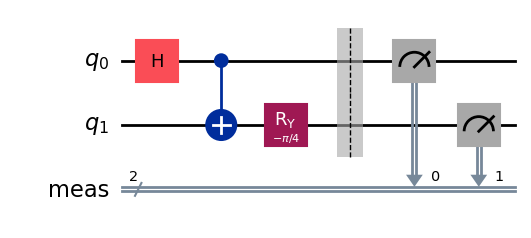

In [12]:
qc = gen_chsh(0, 0)

qc.draw('mpl')

In [125]:
def cx_chain(n_qubits):
    qc = qiskit.QuantumCircuit(n_qubits)

    half = int(n_qubits / 2)

    for i in range(half - 1):
        qc.cx(i, i + 1)
        qc.cx(i + 1, i)

        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))
        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))

    qc.cx(int(n_qubits/2)-1, int(n_qubits/2))

    for i in reversed(range(half - 1)):
        qc.cx(i + 1, i)
        qc.cx(i, i + 1)

        qc.cx(n_qubits - (i + 2), n_qubits - (i + 1))
        qc.cx(n_qubits - (i + 1), n_qubits - (i + 2))

    return qc

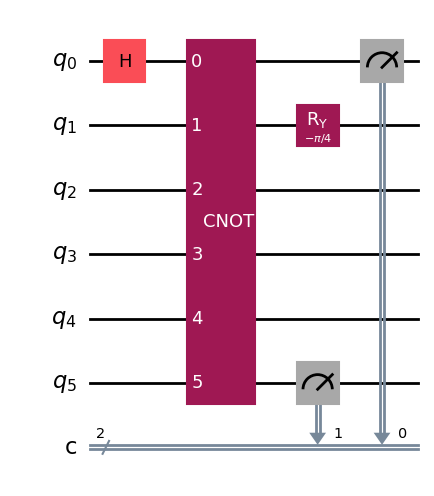

In [126]:
custom_cnot = cx_chain(6).to_gate(label="CNOT")
qc = qiskit.QuantumCircuit(6, 2)

qc.h(0)
qc.append(custom_cnot, [0, 1, 2, 3, 4, 5])
qc.ry(-np.pi/4, 1)
qc.measure(0, 0)
qc.measure(5, 1)

qc.draw("mpl")